# Q4_ErblinMarku_210762815_NLP_ECS763P_ASSIGNMENT_1_SEQUENCE_CLASSIFICATION
# Assignment 1: CRF sequence tagging for Movie Queries

**NOTEBOOK/CODE SUBMISSION:

In [1]:
conda install -c conda-forge sklearn-crfsuite

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import sys


from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report


from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [2]:
def get_raw_data_from_bio_file(fpath):
    f = open(fpath)
    data = []  
    current_sent = [] 
    for line in f:
        if line == "\n": 
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [3]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [4]:
# have a look at the first example
print(raw_training_data[0], "\n")

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')] 



In [5]:
# here I initialize the POS tagger
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")

In [6]:
def preProcess(example):
    #remove the second part of the tuple so I can get only the word
    singles=[w[0] for w in example]
    #here I apply the postagger to the words
    pos_singles = posttagger.tag(singles)
    #now I iterate in a for loop to get the word and the POS tag as the first part of tuple and the BIO tag as the second part of the tuple
    preprocessed_example = []
    for s, w in zip(pos_singles, example):
        preprocessed_example.append((w[0] + '@' + s[1],w[1]))
    return preprocessed_example

In [7]:
training_data = [preProcess(example) for example in raw_training_data]

In [8]:
# check the effect of pre-processing with the POS tagger
print(training_data[0],"\n")
print(training_data[1],"\n")

[('steve@PRPVBP', 'B-Actor'), ('mcqueen@VBN', 'I-Actor'), ('provided@VBN', 'O'), ('a@DT', 'O'), ('thrilling@NN', 'B-Plot'), ('motorcycle@NN', 'I-Plot'), ('chase@NN', 'I-Plot'), ('in@IN', 'I-Plot'), ('this@DT', 'I-Plot'), ('greatest@JJS', 'B-Opinion'), ('of@IN', 'I-Opinion'), ('all@DT', 'I-Opinion'), ('ww@NNP', 'B-Plot'), ('2@NNP', 'I-Plot'), ('prison@NNP', 'I-Plot'), ('escape@NN', 'I-Plot'), ('movies@NNS', 'I-Plot')] 

[('liza@NNP', 'B-Actor'), ('minnelli@NNP', 'I-Actor'), ('and@CC', 'O'), ('joel@NNP', 'B-Actor'), ('gray@NNP', 'I-Actor'), ('won@NNP', 'B-Award'), ('oscars@NNS', 'I-Award'), ('for@IN', 'O'), ('their@PRP$', 'O'), ('roles@NNS', 'O'), ('in@IN', 'O'), ('this@DT', 'O'), ('1972@NN', 'B-Year'), ('movie@NN', 'O'), ('that@WDT', 'B-Plot'), ('follows@VBZ', 'I-Plot'), ('nightclub@NN', 'I-Plot'), ('entertainers@NNS', 'I-Plot'), ('in@IN', 'I-Plot'), ('berlin@NNP', 'I-Plot'), ('as@IN', 'I-Plot'), ('the@DT', 'I-Plot'), ('nazis@NNS', 'I-Plot'), ('come@VBP', 'I-Plot'), ('to@TO', 'I-Plot'),

In [9]:
#imported the train_test_split from the sklearn data science library so I can use it to divide the data in two subsets used for training and testing
from sklearn.model_selection import train_test_split

""" - I used most train_test_split function when spliting the training data in two subsets.
    - Assigned the sizes of train data at 80% leaving the test data automatically at 20%.
    - Used only x_train and and x_test since our data is already in pairs of tuples format and I dont need to set data and target attributes to the training_data.
    - random_state is set to 0 because I want to see the changes in the training when I change the tagger"""

x_train, x_test =train_test_split(training_data, train_size=0.8, random_state=42)


#doing some tests so I can see if the split was succesful
#the outputs match the 80%-20% split.

print(len(training_data))
print(len(x_train))
print(len(x_test))
print(training_data[1],"\n")
print(x_train[1],"\n")
print(x_test[1],"\n")

7816
6252
1564
[('liza@NNP', 'B-Actor'), ('minnelli@NNP', 'I-Actor'), ('and@CC', 'O'), ('joel@NNP', 'B-Actor'), ('gray@NNP', 'I-Actor'), ('won@NNP', 'B-Award'), ('oscars@NNS', 'I-Award'), ('for@IN', 'O'), ('their@PRP$', 'O'), ('roles@NNS', 'O'), ('in@IN', 'O'), ('this@DT', 'O'), ('1972@NN', 'B-Year'), ('movie@NN', 'O'), ('that@WDT', 'B-Plot'), ('follows@VBZ', 'I-Plot'), ('nightclub@NN', 'I-Plot'), ('entertainers@NNS', 'I-Plot'), ('in@IN', 'I-Plot'), ('berlin@NNP', 'I-Plot'), ('as@IN', 'I-Plot'), ('the@DT', 'I-Plot'), ('nazis@NNS', 'I-Plot'), ('come@VBP', 'I-Plot'), ('to@TO', 'I-Plot'), ('power@VB', 'I-Plot')] 

[('what@WP', 'O'), ('2012@DT', 'B-Year'), ('movie@NN', 'O'), ('features@NNS', 'O'), ('a@DT', 'O'), ('struggling@NN', 'B-Plot'), ('screenwriter@NN', 'I-Plot'), ('who@WP', 'I-Plot'), ('gets@VBZ', 'I-Plot'), ('caught@VBN', 'I-Plot'), ('up@RP', 'I-Plot'), ('in@IN', 'I-Plot'), ('the@DT', 'I-Plot'), ('los@NNP', 'I-Plot'), ('angeles@NNP', 'I-Plot'), ('criminal@NNP', 'I-Plot'), ('underw

In [10]:
_pattern = re.compile(r"\d")
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    
    token = tokens[idx]
    feature_list = []
    #here I have to split again at the pos tagg
    pos_feature=token.split('@')
    token=pos_feature[0]
    feature_list.append("pTag_" + pos_feature[1])
    #create a var to store the split, and then split the 
    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [11]:
# Train the CRF BIO-tag tagger
#installed the python crfsuite and imported it here so we can use
import sklearn_crfsuite
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function
#replace the training_data with x_train so we can train the 80% of the corpus
print("training tagger...")
ct.train(x_train, TAGGER_PATH)
print("done")

training tagger...
done


In [12]:
# let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [13]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
#raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
#test_data = [preProcess(example) for example in raw_test_data]
print(len(x_test), "instances")
print(sum([len(sent) for sent in x_test]), "words")

1564 instances
31889 words


In [14]:
print("testing tagger...")
preds = []
y_test = []
for sent in x_test:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [15]:
# Output the classification report (which you should save each time for comparing your models)
classReport_afterSplit = classification_report(y_test, preds)
print(classReport_afterSplit)
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.86      0.89      0.88       967
         B-Award       0.81      0.61      0.70        62
B-Character_Name       0.68      0.24      0.35       217
      B-Director       0.79      0.70      0.74       357
         B-Genre       0.82      0.72      0.77       684
       B-Opinion       0.43      0.31      0.36       165
        B-Origin       0.51      0.34      0.41       157
          B-Plot       0.49      0.45      0.47      1321
         B-Quote       0.40      0.21      0.28        19
  B-Relationship       0.75      0.46      0.57       134
    B-Soundtrack       0.00      0.00      0.00        11
          B-Year       0.96      0.97      0.96       500
         I-Actor       0.86      0.90      0.88      1179
         I-Award       0.75      0.79      0.77       124
I-Character_Name       0.61      0.31      0.41       141
      I-Director       0.83      0.72      0.77       316
         I-Ge

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
###### 4 Question #######
import pandas as pd
from sklearn.metrics import classification_report
report_dict3 = classification_report(y_test, preds, output_dict=True)
pd.DataFrame(report_dict3)

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,B-Actor,B-Award,B-Character_Name,B-Director,B-Genre,B-Opinion,B-Origin,B-Plot,B-Quote,B-Relationship,...,I-Origin,I-Plot,I-Quote,I-Relationship,I-Soundtrack,I-Year,O,accuracy,macro avg,weighted avg
precision,0.864185,0.808511,0.684211,0.786164,0.816225,0.428571,0.509434,0.491257,0.400000,0.753086,...,0.603448,0.841781,0.323810,0.564815,0.0,0.725000,0.870200,0.824234,0.617368,0.818430
recall,0.888314,0.612903,0.239631,0.700280,0.720760,0.309091,0.343949,0.446631,0.210526,0.455224,...,0.620968,0.939082,0.354167,0.389776,0.0,0.743590,0.813398,0.824234,0.531793,0.824234
f1-score,0.876084,0.697248,0.354949,0.740741,0.765528,0.359155,0.410646,0.467883,0.275862,0.567442,...,0.612083,0.887773,0.338308,0.461248,0.0,0.734177,0.840841,0.824234,0.562549,0.818258
support,967.000000,62.000000,217.000000,357.000000,684.000000,165.000000,157.000000,1321.000000,19.000000,134.000000,...,620.000000,12804.000000,96.000000,313.000000,25.0,39.000000,11061.000000,0.824234,31889.000000,31889.000000


In [17]:
#Get the Precision values sorted for the analysis of False positives in Error Analysis 1, we sort and take the first 5 values.
pr= pd.DataFrame(report_dict3)
data1=pr.iloc[0,:]
sorted_precision = data1.sort_values()
sorted_precision.iloc[0:5]

B-Soundtrack    0.000000
I-Soundtrack    0.000000
I-Opinion       0.210526
I-Quote         0.323810
B-Quote         0.400000
Name: precision, dtype: float64

In [18]:
#looking at the top 5 categories with the lowest precision , 
#we have to deal with only 3 since the first 2 have 0 precision which means these categories dont have sentences
print("printing sentences")
categ=['B-Soundtrack','I-Soundtrack','B-Quote', 'I-Quote','I-Opinion']#use a list of our categories so we filter the others,'B-Quote', 

for sent in x_test:
    grt = [s[1] for s in sent]
    predic = [x[1] for x in ct.tag([s[0] for s in sent])]
    sentences = [s[0] for s in sent]
    #use n to limit the printing of sentences to only one time if more than one word happens to be a FP, which in our case happens a lot.
    n=2
    #I itereate and check for FP, which means the predicted tag found in one of our categories is different from than the tag in sent_true 
    for p, g, s in zip(predic,grt,sentences):
        if p not in categ:#focus only in the 3 categories we want
            continue
        if p != g:#check if it is FP
            n-=1
            if n>0:
                print(sentences)#First I print the sentence where the FP is found
            print('GroundTruth:{1}->Predicted:{2}-->"{0}"'.format(s,g,p)) #And then all the word found in the above sentence which are FP with their prediction, ground truth and the word
print("done")

printing sentences
['what@WP', 'is@VBZ', 'the@DT', 'name@NN', 'of@IN', 'the@DT', 'fifth@JJ', 'movie@NN', 'in@IN', 'the@DT', 'series@NN', 'about@IN', 'how@WRB', 'you@PRP', 'ca@NNP', 'n@NNP', 't@NNP', 'cheat@NNP', 'death@NN', 'or@CC', 'fate@VB']
GroundTruth:I-Plot->Predicted:B-Quote-->"you@PRP"
GroundTruth:I-Plot->Predicted:I-Quote-->"ca@NNP"
GroundTruth:I-Plot->Predicted:I-Quote-->"n@NNP"
GroundTruth:I-Plot->Predicted:I-Quote-->"t@NNP"
GroundTruth:I-Plot->Predicted:I-Quote-->"cheat@NNP"
GroundTruth:I-Plot->Predicted:I-Quote-->"death@NN"
GroundTruth:I-Plot->Predicted:I-Quote-->"or@CC"
GroundTruth:I-Plot->Predicted:I-Quote-->"fate@VB"
['what@WP', 'critically@RB', 'acclaimed@JJ', 'war@NN', 'film@NN', 'directed@VBN', 'by@IN', 'steven@NNP', 'spielberg@NNP', 'was@VBD', 'upset@JJ', 'for@IN', 'the@DT', 'oscar@NN', 'for@IN', 'best@JJS', 'picture@NN']
GroundTruth:B-Genre->Predicted:I-Opinion-->"war@NN"
['what@WP', '2011@NNP', 'gary@NNP', 'mckendry@NNP', 'thriller@NNP', 'features@NNP', 'jason@NNP'

In [19]:
#Get the recall values sorted for the analysis of False negatives in Error Analysis 2, we look at the 5 classes with lowest Recall values
rc= pd.DataFrame(report_dict3)
data2=rc.iloc[1,:]
sorted_recall = data2.sort_values()
sorted_recall.iloc[0:5]

I-Soundtrack        0.000000
B-Soundtrack        0.000000
I-Opinion           0.144144
B-Quote             0.210526
B-Character_Name    0.239631
Name: recall, dtype: float64

In [20]:
print("printing sentences for the FN...")
categ=['I-Soundtrack','B-Soundtrack','I-Opinion','B-Quote', 'B-Character_Name']#use a list of our categories so we filter the others
for sent in x_test:
    grt = [s[1] for s in sent]
    predic = [x[1] for x in ct.tag([s[0] for s in sent])]
    sentences = [s[0] for s in sent]
    n=2
    for g, p, s in zip(grt,predic,sentences):
        if g not in categ:#focus only in the categories we want
            continue
        if g != p:#check if it is FN
            n-=1
            if n>0:
                print(sentences)#First I print the sentence where the FN is found
            print('GroundTruth:{1}->Predicted:{2}-->"{0}"'.format(s,g,p))
print("done")

printing sentences for the FN...
['what@WP', 'is@VBZ', 'the@DT', 'name@NN', 'of@IN', 'the@DT', 'disney@NNP', 'classic@NNP', 'featuring@NNP', 'woodland@NNP', 'animals@NNS', 'and@CC', 'a@DT', 'bunny@NN', 'named@VBN', 'thumper@NNP']
GroundTruth:B-Character_Name->Predicted:I-Plot-->"thumper@NNP"
['what@WP', 'is@VBZ', 'the@DT', 'marvel@NN', 'comic@JJ', 'movie@NN', 'about@IN', 'the@DT', 'god@NNP', 'of@IN', 'thunder@NN', 'who@WP', 'comes@VBZ', 'to@IN', 'earth@NNP', 'and@CC', 'fights@NNS', 'his@PRP$', 'brother@NN', 'loki@NN']
GroundTruth:B-Character_Name->Predicted:I-Plot-->"loki@NN"
['what@WP', 's@PDT', 'the@DT', 'kubrick@NN', 'film@NN', 'set@NN', 'in@IN', 'the@DT', 'future@NN', 'and@CC', 'involves@VBZ', 'alex@NN', 'and@CC', 'his@PRP$', 'band@NN', 'of@IN', 'thugs@NNS']
GroundTruth:B-Character_Name->Predicted:I-Plot-->"alex@NN"
['a@DT', 'clue@NN', 'a@DT', 'clue@NN', 'my@PRP$', 'kingdom@NN', 'for@IN', 'a@DT', 'clue@NN', 'about@IN', 'which@WDT', 'movie@NN', 'i@PRP', 'm@VBP', 'asking@VBG', 'about

In [21]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    cm = confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

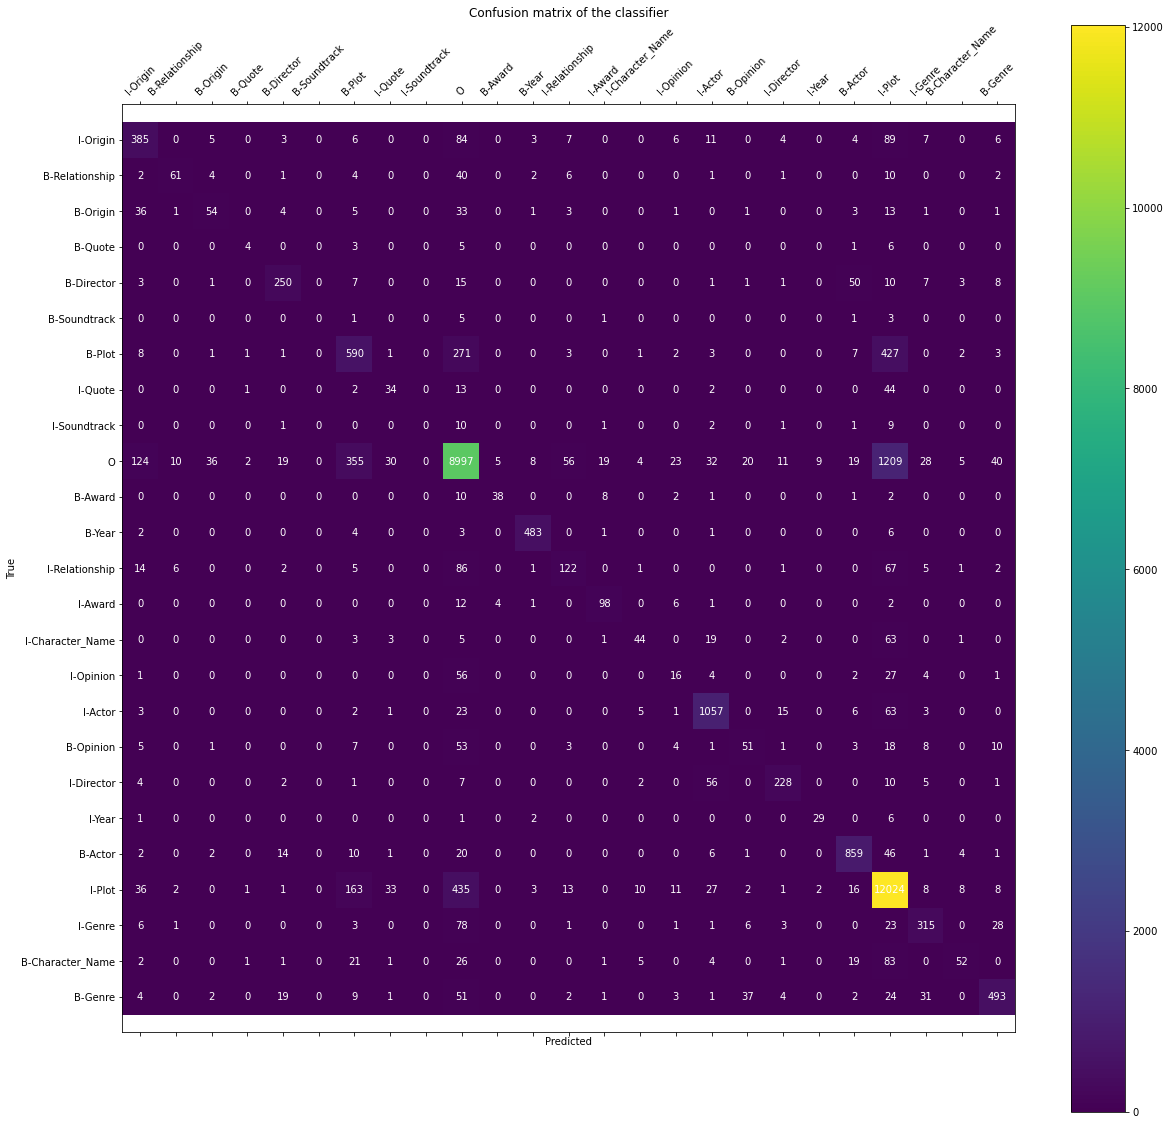

In [23]:
confusion_matrix_heatmap(y_test, preds)

In [24]:
def print_transition_weights(transitions):
    """Sort the transitions between states/labels from highest to
    lowest strengths and print out."""
    ranked_transitions = [x for x in sorted(transitions,
                                               key=lambda x:x[1], reverse=True)]
    for (label_from, label_to), weight in ranked_transitions:
        print("%0.6f %-8s -> %s" % (weight, label_from, label_to))

In [25]:
print_transition_weights(ct._tagger.info().transitions.items())

8.580809 B-Plot   -> I-Plot
8.323982 B-Actor  -> I-Actor
7.986775 I-Plot   -> I-Plot
7.562025 B-Origin -> I-Origin
7.490102 I-Quote  -> I-Quote
7.463322 B-Director -> I-Director
7.242204 I-Origin -> I-Origin
7.112819 B-Relationship -> I-Relationship
7.012352 B-Quote  -> I-Quote
6.962202 I-Opinion -> I-Opinion
6.954018 I-Relationship -> I-Relationship
6.860967 B-Character_Name -> I-Character_Name
6.650451 I-Soundtrack -> I-Soundtrack
6.579385 B-Genre  -> I-Genre
6.499765 B-Opinion -> I-Opinion
6.453301 B-Award  -> I-Award
6.331301 I-Award  -> I-Award
6.233703 I-Genre  -> I-Genre
6.231907 B-Soundtrack -> I-Soundtrack
5.826373 I-Actor  -> I-Actor
5.606951 I-Character_Name -> I-Character_Name
4.851263 I-Director -> I-Director
4.525612 I-Year   -> I-Year
3.881945 B-Year   -> I-Year
3.744899 B-Character_Name -> B-Plot
3.370358 I-Character_Name -> B-Plot
3.220364 O        -> O
3.041680 O        -> B-Plot
2.954027 I-Actor  -> B-Plot
2.891792 B-Plot   -> B-Character_Name
2.755502 B-Year   -> B-

In [30]:
def print_most_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=True) \
         if x[0][1] not in excluded_classes][:top_k]
    n=20 #added this counter to see only the top predicted features
    for (attr, label), weight in ranked_state_features:
        n-=1
        if n>0:
            print("%0.6f %-8s %s" % (weight, label, attr))

In [31]:
print_most_predictive_state_features(ct._tagger.info().state_features.items())

5.681565 B-Year   HAS_NUM
4.217382 I-Year   WORD_s
3.745078 B-Genre  WORD_animated
2.925386 B-Genre  WORD_thriller
2.880341 B-Genre  WORD_action
2.719257 B-Opinion WORD_blockbuster
2.576186 B-Relationship SUF_uel
2.547041 B-Award  WORD_oscar
2.470942 B-Genre  WORD_animation
2.441655 B-Award  SUF_car
2.428851 B-Director WORD_disney
2.347476 I-Genre  WORD_animated
2.330754 B-Relationship WORD_remake
2.313416 I-Genre  WORD_fiction
2.310457 B-Genre  WORD_war
2.309467 B-Genre  WORD_musical
2.297356 B-Relationship WORD_sequel
2.248805 B-Genre  WORD_comedy
2.212318 B-Genre  WORD_horror


In [32]:
#Write the above function to predict the least predictive features so I can see where to make improvements
def print_least_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=False) \
         if x[0][1] not in excluded_classes][:top_k]
    n=20
    for (attr, label), weight in ranked_state_features:
        n-=1
        if n>0:
            print("%0.6f %-8s %s" % (weight, label, attr))

In [33]:
print_least_predictive_state_features(ct._tagger.info().state_features.items())

-1.707392 I-Actor  pTag_IN
-1.573079 I-Actor  WORD_s
-1.549485 I-Plot   SUF_car
-1.479662 I-Plot   WORD_based
-1.399975 I-Plot   SUF_u
-1.391552 B-Character_Name pTag_DT
-1.371295 I-Actor  SUF_ar
-1.351006 I-Plot   WORD_series
-1.322710 I-Plot   SUF_yan
-1.315703 I-Plot   WORD_called
-1.287695 I-Opinion pTag_NNP
-1.265811 B-Genre  pTag_DT
-1.223480 I-Genre  SUF_t
-1.204246 I-Plot   WORD_movies
-1.174556 I-Plot   WORD_featuring
-1.166603 I-Plot   WORD_involves
-1.152670 I-Plot   SUF_tt
-1.148043 I-Plot   WORD_cartoon
-1.146207 I-Genre  SUF_s


# 4. Incorporating POS tags as features (15 marks)
Use the CRF part-of-speech (POS) tagger as shown below to add POS tags to the words in the training data. Do this by altering the `preProcess` function above. Note the CRF tagger only takes strings as input so you will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and you will also have to then split on this special symbol in the feature extraction function `get_features` to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by `feature_list.append("WORD_" + token)`. Re-run the training and testing code on your 80%/20% training/dev split from question 1 and record the results from the classification report as text in this file for comparison of the accuracy metrics against not using POS tags- try to see any improvemements across the classes.